## Import 및 Device 설정
- 라이브러리 임포트
- GPU 사용 여부 체크

In [3]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 이미지 전처리
- 관측 이미지 리사이즈
- RGB 이미지 그레이스케일로 변경

In [4]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

## 환경 클래스
- **초기화**
    - **no_operation:** 초기 reset 후 no-op 액션을 몇 번 수행하여 초기 상태를 다양하게 함
    - **skip_frames:** 한 번의 step에서 여러 프레임을 스킵하여 계산량을 줄이고 더 추상화된 동작을 하게 함
    - **stack_frames:** 마지막 n개 프레임을 쌓아(스택) 관측으로 사용한다. 이렇게 하면 단일 이미지만으로는 파악하기 어려운 속도/이동 정보 등을 시간적 연속성으로 얻을 수 있음
- **reset:** 환경 리셋 후 no-op 수행, 관측 이미지 전처리 후 초기 스택 상태 생성
- **step:** skip_frames 동안 같은 액션을 반복, reward 합산, 최종 관측 이미지 stack에 추가

In [5]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info

## CNN 모델
- DQN의 Q-network로 사용할 CNN
- **입력:** 스택된 프레임(흑백 이미지)를 받아 CNN으로 feature 추출 후 완전연결층을 통해 액션별 Q값 출력
- **in_channels:** 스택된 프레임 수
- **out_channels:** 액션 개수
- **구조:** conv 계층 + FC 계층

In [6]:
class CNN(nn.Module):
  def __init__(self, in_channels, out_channels, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self._n_features = 32 * 9 * 9

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=4, stride=2),
        nn.ReLU(),
    )

    self.fc = nn.Sequential(
        nn.Linear(self._n_features, 256),
        nn.ReLU(),
        nn.Linear(256, out_channels),
    )


  def forward(self, x):
    x = self.conv(x)
    x = x.view((-1, self._n_features))
    x = self.fc(x)
    return x

## ReplayMemory 클래스
- **Transition:** 강화학습 에이전트의 경험을 저장하기 위한 데이터 구조
- **init:** capacity 변수를 사용해 리플레이 메모리에 저장할 최대 경험수 정의
- **push:** Transition을 리플레이 메모리에 추가
- **sample:** batch_size만큼 Transition 랜덤 샘플링

In [7]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN 클래스
- **주요 변수:**
    - **action_space:** 환경의 액션 공간
    - **network:** 주 네트트워크로 Q-network
    - **target_netwrork:** 타겟 Q-network로 일정 주기마다 복사해서 학습
    - **optimizer:** AdamW 옵티마이저
    - **memory:** 리플레이 메모리
    - **eps_threshold:** epsilon-greedy 정책에서 탐색 비율
- **select_action:** e-greedy 정책을 사용해 액션 선택
- **train:** 리플레이 메모리에서 mini-batch를 샘플링해 Q-network 업데이트
- **copy_weights:** 주 네트워크 가중치를 타겟 네트워크에 복사
- **get_loss:** 현재까지 기록된 손실 값 반환
- **save_model:** 타겟 네트워크의 가중치를 파일로 저장
- **load_model:** 저장된 파일로부터 네트워크 가중치를 불러오기

In [8]:
class DQN:
  def __init__(self, action_space, batch_size=256, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=1000, lr=0.001):
    self._n_observation = 4
    self._n_actions = 5
    self._action_space = action_space
    self._batch_size = batch_size
    self._gamma = gamma
    self._eps_start = eps_start
    self._eps_end = eps_end
    self._eps_decay = eps_decay
    self._lr = lr
    self._total_steps = 0
    self._evaluate_loss = []
    self.network = CNN(self._n_observation, self._n_actions).to(device)
    self.network = nn.DataParallel(self.network, device_ids=[0,1,2,3])
    self.target_network = CNN(self._n_observation, self._n_actions).to(device)
    self.target_network = nn.DataParallel(self.target_network, device_ids=[0,1,2,3])
    self.target_network.load_state_dict(self.network.state_dict())
    self.optimizer = optim.AdamW(self.network.parameters(), lr=self._lr, amsgrad=True)
    self._memory = ReplayMemory(10000)

  """
  This function is called during training & evaluation phase when the agent
  interact with the environment and needs to select an action.

  (1) Exploitation: This function feeds the neural network a state
  and then it selects the action with the highest Q-value.
  (2) Evaluation mode: This function feeds the neural network a state
  and then it selects the action with the highest Q'-value.
  (3) Exploration mode: It randomly selects an action through sampling

  Q -> network (policy)
  Q'-> target network (best policy)
  """
  def select_action(self, state, evaluation_phase=False):

    # Generating a random number for eploration vs exploitation
    # 0~1 사이 랜덤 실수 생성해 탐험과 활용 결정
    sample = random.random()

    # Calculating the threshold - the more steps the less exploration we do
    # eps_start에서 감쇠율에 따라 점점 감소하다가 최종 eps_end에 수렴
    eps_threshold = self._eps_end + (self._eps_start - self._eps_end) * math.exp(-1. * self._total_steps / self._eps_decay)
    self._total_steps += 1

    # 평가 모드에 경우 탐험 없이 타겟 네트워크를 사용해 가장 Q값이 높은 액션 선택
    if evaluation_phase:
      with torch.no_grad():
        return self.target_network(state).max(1).indices.view(1, 1)
    # 활용: 주 네트워크를 사용해 가장 Q값이 높은 액션 선택
    elif sample > eps_threshold:
      with torch.no_grad():
        return self.network(state).max(1).indices.view(1, 1)
    # 탐험: 랜덤하게 액션을 선택
    else:
      return torch.tensor([[self._action_space.sample()]], device=device, dtype=torch.long)

  def train(self):

    if len(self._memory) < self._batch_size:
        return

    # Initializing our memory
    # batch_size만큼 샘플링
    transitions = self._memory.sample(self._batch_size)

    # Initializing our batch
    batch = Transition(*zip(*transitions))

    # Saving in a new tensor all the indices of the states that are non terminal
    # 다음 상태가 종료되지 않은 상태를 표시하는 마스크
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

    # Saving in a new tensor all the non final next states
    # 비종료 상태의 다음 상태들을 하나의 텐서로 결합
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # 배치 생성
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Feeding our Q network the batch with states and then we gather the Q values of the selected actions
    # Q-network를 통한 현재 상태의 Q값 계산 
    state_action_values = self.network(state_batch).gather(1, action_batch)

    # We then, for every state in the batch that is NOT final, we pass it in the target network to get the Q'-values and choose the max one\
    # 타겟 네트워크를 통한 다음 상태 Q값 계산
    next_state_values = torch.zeros(self._batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values

    # Computing the expecting values with: reward + gamma * max(Q')
    # Q기대값 계산
    expected_state_action_values = (next_state_values * self._gamma) + reward_batch

    # Defining our loss criterion
    # 손실 함수 정의 및 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Updating with back propagation
    # 역전파 및 네트워크 업데이트
    self.optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
    self.optimizer.step()

    # 손실 기록
    self._evaluate_loss.append(loss.item())

    return

  def copy_weights(self):
    self.target_network.load_state_dict(self.network.state_dict())

  def get_loss(self):
    return self._evaluate_loss

  def save_model(self, i):
    torch.save(self.target_network.state_dict(), f'./origin_dqn/model_weights_{i}.pth')

  def load_model(self, i):
    self.target_network.load_state_dict(torch.load(f'./origin_dqn/model_weights_{i}.pth', map_location=device))

## 학습 코드

In [7]:
#초기 변수 설정
rewards_per_episode = [] #각 에피소드별 받은 총 보상 저장
episode_duration = [] #각 에피소드 지속 시간
average_episode_loss = [] # 각 에피소드 동안 평균 손실 값 저장

episodes = 1000 #학습할 에피소드 수
C = 5 #타겟 네트워크 업데이트 주기

#환경 및 에이전트 초기화
env = gym.make('CarRacing-v2', lap_complete_percent=0.95, continuous=False)
n_actions = env.action_space
agent = DQN(n_actions)

#메인 학습으로 1000번 반복
for episode in range(1, episodes + 1):

  #10번마다 진행상황
  if episode % 10 == 0:
    print(f"{episode} episodes done")

  #에피소드마다 환경 재생성
  env = gym.make('CarRacing-v2', continuous=False)
  env = CarEnvironment(env)

  #환경 초기화
  state, info = env.reset()

  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

  episode_total_reward = 0

  for t in count():
    #현재 상태 기반 에이전트 액션 선택
    action = agent.select_action(state)
    #환경에 액션 적용 및 결과 관측
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    episode_total_reward += reward
    done = terminated or truncated

    #다음 상태 결정
    if terminated:
      next_state = None
      print("Finished the lap successfully!")
    else:
      next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    #리플레이 메모리에 경험 저장
    agent._memory.push(state, action, next_state, reward)
    #상태 업데이트
    state = next_state
    #에이전트 학습
    agent.train()

    #에피소드 종료 시 처리
    if done:
      #리플레이 메모리에 충분한 데이터(최소 128)개 경험이 저장되어있을 때 통계로 기록
      if agent._memory.__len__() >= 128:
        episode_duration.append(t + 1)
        rewards_per_episode.append(episode_total_reward)
        ll = agent.get_loss()
        average_episode_loss.append(sum(ll) / len(ll))
      break

    #100 에피소드마다 에이전트의 타겟 네트워크 가중치 파일 및 통계 저장
    if episode % 100 == 0:
      agent.save_model(episode)
      with open('./origin_dqn/statistics.pkl', 'wb') as f:
        pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)


  if episode % C == 0:
    agent.copy_weights()

#최종 모델 저장 및 통계 저장
agent.save_model(episodes)
with open('./origin_dqn/statistics.pkl', 'wb') as f:
  pickle.dump((episode_duration, rewards_per_episode, average_episode_loss), f)

10 episodes done
20 episodes done
30 episodes done
40 episodes done
50 episodes done
Finished the lap successfully!
60 episodes done
Finished the lap successfully!
Finished the lap successfully!
70 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
80 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
90 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
100 episodes done
Finished the lap successfully!
110 episodes done
Finished the lap successfully!
Finished the lap successfully!
Finished the lap successfully!
120 episodes done
Finished the lap successfully!
130 episodes done
140 episodes done
150 episodes done
160 episodes done
170 episodes done
180 episodes done
190 episodes done
Finished the lap

## 통계 시각화 함수
- 데이터 시각화
- 이미지 저장
- 분석

In [9]:
def plot_statistics(x, y, title, x_axis, y_axis):
    plt.plot(x, y)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_")}.png')  # 공백 대신 밑줄 사용
    plt.show()
     

## 평가 코드

/tmp/ipykernel_2909187/2651966534.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target_network.load_state_dict(torch.load(f'./origin_dqn/model_weights_{i}.pth',

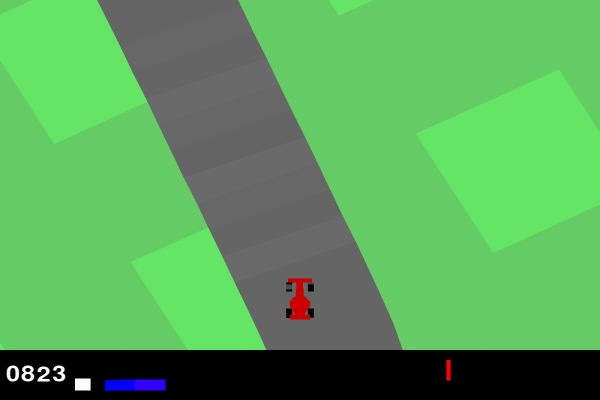

816.8879598662021


In [10]:
#환경 생성 및 불러오기
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)
n_actions = eval_env.action_space
agent = DQN(n_actions)
agent.load_model(1000)

#변수 초기화
frames = []
scores = 0
s, _ = eval_env.reset()

eval_env.np_random = np.random.default_rng(42)

done, ret = False, 0

#렌더링을 위한 함수 및 디스플레이 핸들
from PIL import Image as PILImage
def render2img(_img): return PILImage.fromarray(_img, "RGB")
handle = display(None, display_id=True)
while not done:
    #현재 스텝의 프레임 이미지를 받아 업데이트 및 저장
    _render = eval_env.render()
    handle.update(render2img(_render))
    frames.append(_render)
    #상태, 액션 선택 및 변환
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True) #평가 모드
    discrete_action = a.item() % 5
    #환경 스텝 적용 및 결과 관측
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    #상태 및 보상 업데이트
    s = s_prime
    ret += r
    done = terminated or truncated
    #에피소드 종료 시 처리
    if terminated:
      print(terminated)

#총 점수 업데이트 및 출력
scores += ret
print(scores)


def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random

    #비디오 파일 이름 설정
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP80')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))

    #프레임을 비디오에 추가
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()

## 통계 데이터 시각화 및 평가 결과 비디오에 저장

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


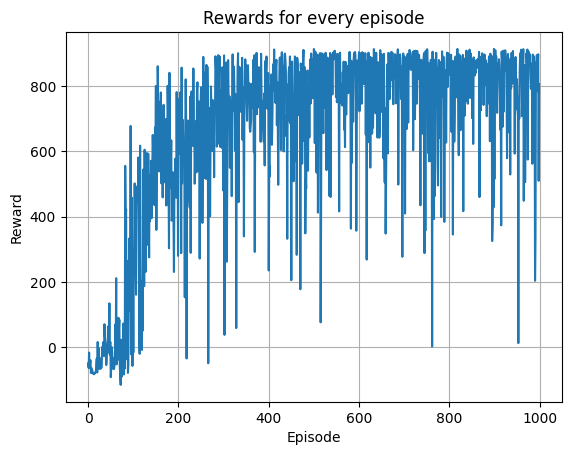

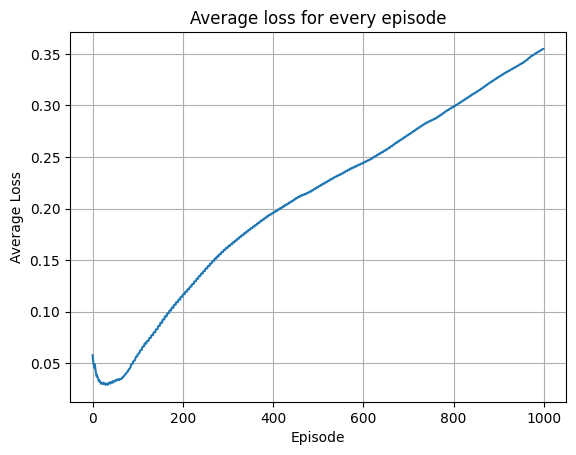

In [13]:
#비디오 애니메이션 생성
animate(frames, None)

#통계 데이터 로드
with open('./origin_dqn/statistics.pkl', 'rb') as f:
    data_tuple = pickle.load(f)

episode_duration, rewards_per_episode, average_episode_loss = data_tuple

x = [k for k in range(1000)]

rewards_per_episode = [tensor.cpu() if tensor.is_cuda else tensor for tensor in rewards_per_episode]

#통계 데이터 시각화
plot_statistics(x, rewards_per_episode, "Rewards for every episode", "Episode", "Reward")
plot_statistics(x, average_episode_loss, "Average loss for every episode", "Episode", "Average Loss")